In [1]:
import numpy as np
import pandas as pd
from pymc_marketing.clv import utils
from pymc_marketing.clv import ParetoNBDModel
from pymc_marketing.prior import Prior

import pytensor

#set flag to fix open issue
pytensor.config.cxx = '/usr/bin/clang++'

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Create a simple dataset for testing:

In [2]:
d = [
    [1, "2015-01-01", 1],
    [1, "2015-02-06", 2],
    [2, "2015-01-01", 2],
    [3, "2015-01-01", 3],
    [3, "2015-01-02", 1],
    [3, "2015-01-05", 5],
    [4, "2015-01-16", 6],
    [4, "2015-02-02", 3],
    [4, "2015-02-05", 3],
    [4, "2015-02-05", 2],
    [5, "2015-01-16", 3],
    [5, "2015-01-17", 1],
    [5, "2015-01-18", 8],
    [6, "2015-02-02", 5],
]
test_data = pd.DataFrame(d, columns=["id", "date", "monetary_value"])

Note customer 4 made two purchases on 2015-02-05. 

`_find_first_transactions` flags the first purchase each customer has made, which must be excluded for modeling. It is called internally by `rfm_summary`.

In [3]:
utils._find_first_transactions(
    transactions=test_data, 
    customer_id_col = "id", 
    datetime_col = "date",
    #monetary_value_col = "monetary_value", 
    #datetime_format = "%Y%m%d",
).reindex()

,id,date,first
0,1,2015-01-01,True
1,1,2015-02-06,False
2,2,2015-01-01,True
3,3,2015-01-01,True
4,3,2015-01-02,False
5,3,2015-01-05,False
6,4,2015-01-16,True
7,4,2015-02-02,False
8,4,2015-02-05,False
10,5,2015-01-16,True


Notice how **9** is missing from the dataframe index. Multiple transactions in the same time period are treated as a single purchase, so the indices for those additional transactions are skipped. 

`rfm_summary` is the primary data preprocessing step for CLV modeling in the continuous, non-contractual domain:

In [4]:
rfm_df = utils.rfm_summary(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    monetary_value_col = "monetary_value",
    observation_period_end = "2015-02-06",
    datetime_format = "%Y-%m-%d",
    time_unit = "W",
    include_first_transaction=True,
)

rfm_df.head()

,customer_id,frequency,recency,monetary_value
0,1,2.0,0.0,1.5
1,2,1.0,5.0,2.0
2,3,2.0,4.0,4.5
3,4,2.0,0.0,7.0
4,5,1.0,3.0,12.0


For MAP fits and covariate models, `rfm_train_test_split` can be used to evaluate models on unseen data. It is also useful for identifying the impact of a time-based event like a marketing campaign.

In [5]:
train_test = utils.rfm_train_test_split(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    train_period_end = "2015-02-01",
    monetary_value_col = "monetary_value",
)

train_test.head()

,customer_id,frequency,recency,T,monetary_value,test_frequency,test_monetary_value,test_T
0,1,0.0,0.0,31.0,0.0,1.0,2.0,5.0
1,2,0.0,0.0,31.0,0.0,0.0,0.0,5.0
2,3,2.0,4.0,31.0,3.0,0.0,0.0,5.0
3,4,0.0,0.0,16.0,0.0,2.0,4.0,5.0
4,5,2.0,2.0,16.0,4.5,0.0,0.0,5.0


`rfm_segments` will assign customer to segments based on their recency, frequency, and monetary value. It uses a quartile-based RFM score approach that is very computationally efficient, but defining custom segments is a rather subjective exercise. The returned dataframe also cannot be used for modeling because it does not zero out the initial transactions.

In [6]:
segments = utils.rfm_segments(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    monetary_value_col = "monetary_value",
    observation_period_end = "2015-02-06",
    datetime_format = "%Y-%m-%d",
    time_unit = "W",
)

/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/utils.py:707: UserWarning: RFM score will not exceed 2 for f_quartile. Specify a custom segment_config
  warnings.warn(


`_expected_cumulative_transactions` is a utility function for creating cumulative plots over time:

In [23]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv"
url_cdnow = "/Users/coltallen/Projects/pymc-marketing/data/cdnow_transactions.csv"
raw_trans = pd.read_csv(url_cdnow)

rfm_data = utils.rfm_summary(
    raw_trans, 
    customer_id_col = "id", 
    datetime_col = "date", 
    datetime_format = "%Y%m%d",
    time_unit = "W",
    observation_period_end = "19970930",
    #time_scaler = 7,
)

model_config = {
    "r_prior": Prior("HalfFlat"),
    "alpha_prior": Prior("HalfFlat"),
    "s_prior": Prior("HalfFlat"),
    "beta_prior": Prior("HalfFlat"),
}

pnbd = ParetoNBDModel(data=rfm_data,model_config=model_config)

pnbd.fit()

df_cum = utils._expected_cumulative_transactions(
    model=pnbd,
    transactions=raw_trans,
    customer_id_col="id",
    datetime_col="date",
    t=25*7,
    datetime_format="%Y%m%d",
    time_unit="W",
    set_index_date=True,
)

df_cum.info()

Output()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 175 entries, 1996-12-30/1997-01-05 to 2000-05-01/2000-05-07
Freq: W-SUN
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   actual     175 non-null    int64  
 1   predicted  175 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.1 KB


In [32]:
date_range = pd.date_range("19970930", periods=50 + 1, freq="D")
date_periods = date_range.to_period("D")
#date_periods[7 - 1 : -1 : 7].astype(int)
range(0, 50 // 7)

range(0, 7)

<Axes: title={'center': 'Tracking Cumulative Transactions'}, xlabel='Time Periods', ylabel='Purchases'>

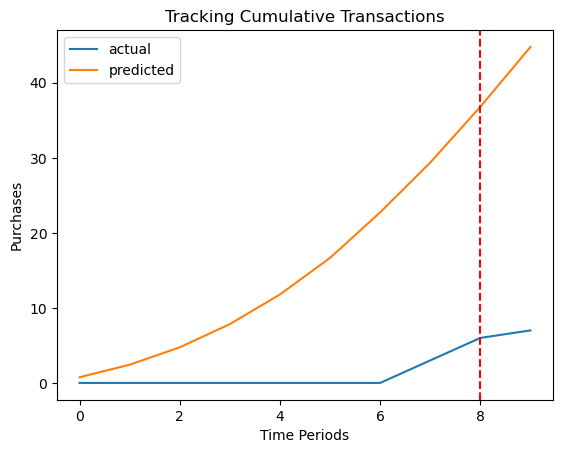

In [38]:
from pymc_marketing.clv.plotting import plot_expected_purchases

plot_expected_purchases(model=pnbd,
    transactions=raw_trans,
    plot_cumulative=True,
    customer_id_col="id",
    datetime_col="date",
    t=10,
    t_cal=8,
    datetime_format="%Y%m%d",
    time_unit="D",
    set_index_date=False,
                       )